In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
data_small = pd.read_csv('/content/data_small.csv')
classes3 = pd.read_csv('/content/classes3.csv')
rhymes = pd.read_csv('/content/rhymes_small2.csv')
rhythm_1 = pd.read_csv('/content/rhythm_1.csv')
rhythm_2 = pd.read_csv('/content/rhythm_2_small.csv')

In [ ]:
rhymes.columns = ['rhyme_scheme']
rhythm_1.columns = ['rhythm_estimate']
rhythm_2.columns = ['rhythm_scheme']

In [ ]:
data_all = pd.concat([data_small, classes3, rhymes, rhythm_1, rhythm_2], axis=1)

In [ ]:
train_data, test_data = train_test_split(data_all, test_size=0.2, random_state=42)

In [ ]:
train_data.shape, test_data.shape,

((13600, 11), (3400, 11))

In [ ]:
train_data.merge(test_data, how='inner', on=['output_text']).shape, train_data.merge(test_data, how='inner', on=['url']).shape

((0, 21), (0, 21))

In [ ]:
test_data.head()

,url,rating,views,output_text,genre,meanf,grammar,emotion,rhyme_scheme,rhythm_estimate,rhythm_scheme
10941,https://www.chitalnya.ru/work/2644583/,27,96,"Не пиши мне длиннющих писем,\nИ прошу, не прос...",лирика,1,1,1,"[-1, 1, -1, 1, -1, 2, 3, 2, 3, 4, 3, 4, -1, 5,...",0.906250,"[3.0, 2.5, 3.0, 3.0, 3.0, 3.0, 3.3333333333333..."
5250,https://www.chitalnya.ru/work/889492/,16,231,"Солнышко пригрело, - мысли набекрень!\nКто мне...",юмор,1,1,0,"[1, 1, 2, 2, -1, -1, 3, 3, 4, 4, 5, 5, 0, 0, 0...",0.833333,"[3.3333333333333335, 3.6666666666666665, 2.5, ..."
10292,https://www.chitalnya.ru/work/3032718/,0,19,"Крестьяне привезли в дар брёвна,\nА Снетогорск...",лирика,1,1,0,"[-1, -1, -1, -1, -1, 1, -1, 1, -1, 2, -1, 2, -...",0.916667,"[3.6666666666666665, 4.0, 2.5, 4.25, 4.0, 4.5,..."
2266,https://www.chitalnya.ru/work/746548/,0,372,"Солнышко в твоей ладошке,\nЩурит взгляд, ласка...",эротика,1,1,0,"[1, 2, 1, 2, 3, 4, 3, 4, 5, 6, 5, 6, 7, 8, 7, ...",0.964286,"[3.3333333333333335, 3.0, 3.6666666666666665, ..."
6398,https://www.chitalnya.ru/work/1441674/,0,104,Строки чеканит мысленный молот\nПесни не будет...,лирика,1,1,0,"[-1, -1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7...",0.916667,"[3.0, 3.6666666666666665, 3.3333333333333335, ..."


In [ ]:
def str2list(x):
  return [float(i) for i in x.replace('[', '').replace(']', '').split(',')]

## Baseline

In [ ]:
# заменяем рейтинг на бинарную переменную 0/не0
# тексты - lower
# жанры - lower
# удаляем ссылки

def preprocess_data(df):
  df_mod = df.copy()
  df_mod.output_text = df_mod.output_text.str.lower()
  df_mod.rating = df_mod.rating.apply(lambda x: 1 if x > 0 else 0)

  return df_mod[['output_text', 'rating']]


train_data_mod = preprocess_data(train_data)
test_data_mod = preprocess_data(test_data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data_mod.output_text)
X_test = vectorizer.transform(test_data_mod.output_text)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42).fit(X_train, train_data_mod.rating)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc_score(test_data_mod.rating, clf.predict_proba(X_test)[:, 1]), accuracy_score(test_data_mod.rating, clf.predict(X_test))

(0.6020446138262567, 0.5882352941176471)

## BERT

In [ ]:
# заменяем рейтинг на бинарную переменную 0/не0
# для стихов может быть важно сохранить структуру (переносы строк), поэтому добавим новый токен для обозначения переносов строк + lower
# жанры приведем к нижнему регистру
# удаляем ссылки

NEWLINE_SPEC_TOKEN = '[NEWLINE]'

def preprocess_data(df):
  df_mod = df.copy()
  df_mod.output_text = df_mod.output_text.str.lower()
  df_mod.output_text = df_mod.output_text.str.replace('\n', NEWLINE_SPEC_TOKEN)
  df_mod.rating = df_mod.rating.apply(lambda x: 1 if x > 0 else 0)
  df_mod.genre = df_mod.genre.str.lower()
  df_mod = df_mod.drop('url', axis=1)

  return df_mod

train_data_mod = preprocess_data(train_data)
test_data_mod = preprocess_data(test_data)

# закондируем жанр через OneHotEncoder
# масштабируем просмотры через StandardScaler

ohe = OneHotEncoder()
ohe.fit(train_data_mod.genre.to_frame())

scaler = StandardScaler()
scaler.fit(train_data_mod.views.to_frame())

StandardScaler()

In [ ]:
# train_data_mod

In [ ]:
# MODEL = 'DeepPavlov/rubert-base-cased'
MODEL = 'cointegrated/rubert-tiny2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.add_special_tokens({'additional_special_tokens': [NEWLINE_SPEC_TOKEN]}) # добавляем новый токен для переноса строк

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1

In [ ]:
# выбираем макс длину последовательности
lst_len_tokens = []
for text in tqdm(train_data_mod.output_text.values):
  lst_len_tokens.append(len(tokenizer.encode(text, add_special_tokens=True)))

In [ ]:
pd.Series(lst_len_tokens).describe(percentiles=[.75, .8, .9, .95])

In [ ]:
# MAX_LENGTH =  # DeepPavlov
# MAX_LENGTH = 344 #cointegrated 90%
MAX_LENGTH = 250 #cointegrated ~75%
# MAX_LENGTH = 210 #cointegrated посередине между 50%(178) и 75%(253)

In [ ]:
class DatasetPoetry(Dataset):
    def __init__(self
                 , texts
                 , genres
                 , views
                 , meanf
                 , grammar
                 , emotion
                 , rhyme_scheme
                 , rhythm_estimate
                 , rhythm_scheme
                 , labels
                 , tokenizer
                 , max_len
                 ):
        self.texts = texts
        self.genres = genres
        self.views = views
        self.labels = labels

        self.meanf = meanf
        self.grammar = grammar
        self.emotion = emotion
        self.rhyme_scheme = rhyme_scheme
        self.rhythm_estimate = rhythm_estimate
        self.rhythm_scheme = rhythm_scheme

        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        genre = self.genres[item]
        views = self.views[item]
        label = self.labels[item]

        meanf = self.meanf[item]
        grammar = self.grammar[item]
        emotion = self.emotion[item]
        rhyme_scheme = self.rhyme_scheme[item]
        rhythm_estimate = self.rhythm_estimate[item]
        rhythm_scheme = self.rhythm_scheme[item]

        model_inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': model_inputs['input_ids'].flatten(),
            'attention_mask': model_inputs['attention_mask'].flatten(),
            'genre': torch.tensor(genre, dtype=torch.long),
            'views': torch.tensor(views, dtype=torch.float),

            'meanf': torch.tensor(meanf, dtype=torch.long),
            'grammar': torch.tensor(grammar, dtype=torch.long),
            'emotion': torch.tensor(emotion, dtype=torch.long),
            'rhyme_scheme': torch.tensor(rhyme_scheme, dtype=torch.long),
            'rhythm_estimate': torch.tensor(rhythm_estimate, dtype=torch.float),
            'rhythm_scheme': torch.tensor(rhythm_scheme, dtype=torch.float),

            'labels': torch.tensor(label, dtype=torch.float).unsqueeze(0) # чтобы размеры labels и выходов модели совпадали
        }

In [ ]:
train_genre_ohe = ohe.transform(train_data_mod.genre.to_frame()).values
train_views_scaled = scaler.transform(train_data_mod.views.to_frame())

train_rhythm_scheme = np.vstack(train_data_mod.rhythm_scheme.apply(str2list).values)
train_rhyme_scheme = np.vstack(train_data_mod.rhyme_scheme.apply(str2list).values)

train_dataset = DatasetPoetry(
    train_data_mod.output_text.values
    , train_genre_ohe
    , train_views_scaled
    , np.expand_dims(train_data_mod.meanf.values, axis=1)
    , np.expand_dims(train_data_mod.grammar.values, axis=1)
    , np.expand_dims(train_data_mod.emotion.values, axis=1)
    , train_rhyme_scheme
    , np.expand_dims(train_data_mod.rhythm_estimate.values, axis=1)
    , train_rhythm_scheme
    , train_data_mod.rating.values
    , tokenizer
    , MAX_LENGTH
)


test_genre_ohe = ohe.transform(test_data_mod.genre.to_frame()).values
test_views_scaled = scaler.transform(test_data_mod.views.to_frame())

test_rhythm_scheme = np.vstack(test_data_mod.rhythm_scheme.apply(str2list).values)
test_rhyme_scheme = np.vstack(test_data_mod.rhyme_scheme.apply(str2list).values)

test_dataset = DatasetPoetry(
    test_data_mod.output_text.values
    , test_genre_ohe
    , test_views_scaled
    , np.expand_dims(test_data_mod.meanf.values, axis=1)
    , np.expand_dims(test_data_mod.grammar.values, axis=1)
    , np.expand_dims(test_data_mod.emotion.values, axis=1)
    , test_rhyme_scheme
    , np.expand_dims(test_data_mod.rhythm_estimate.values, axis=1)
    , test_rhythm_scheme
    , test_data_mod.rating.values
    , tokenizer
    , MAX_LENGTH
)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer


class BERTClassifier(nn.Module):
    # def __init__(self, bert_model_name, num_genres):
    def __init__(self, bert_model_name, num_genres, dim_views=1
                 , dim_meanf=1
                 , dim_grammar=1
                 , dim_emotion=1
                 , dim_rhyme_scheme=20
                 , dim_rhythm_estimate=1
                 , dim_rhythm_scheme=80
                #  , dim_rhyme_emb=5
                #  , dim_rhythm_emb=10
                 ,hidden_dim=128
                 ):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert.resize_token_embeddings(len(tokenizer)) # добавляем новый токен для переноса строк
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)

        # self.rhyme_embedding = nn.Embedding(dim_rhyme_scheme, dim_rhyme_emb)
        # self.rhythm_embedding = nn.Embedding(dim_rhythm_scheme, dim_rhythm_emb)

        # self.linear = nn.Linear(self.bert.config.hidden_size + num_genres + 1, 1)
        #+ dim_meanf
        #+ dim_grammar
        #+ dim_emotion
        #+ dim_rhyme_scheme
        #+ dim_rhythm_estimate
        #+ dim_rhythm_scheme
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views + dim_rhythm_estimate
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views+ dim_meanf + dim_grammar+ dim_emotion  + dim_rhythm_estimate
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views + dim_rhyme_scheme
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views + dim_meanf+ dim_grammar+ dim_emotion+ dim_rhythm_estimate+ dim_rhyme_scheme+ dim_rhythm_scheme
        # final_dim = self.bert.config.hidden_size + num_genres + dim_views + dim_meanf+ dim_grammar+ dim_emotion+ dim_rhythm_estimate+ dim_rhythm_scheme
        final_dim = self.bert.config.hidden_size + num_genres + dim_views
        print(f'final_dim = {final_dim}')
        # print(final_dim)
        # self.linear = nn.Linear(final_dim, 1)
        self.linear = nn.Linear(final_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()


        self.sigmoid = nn.Sigmoid()


    # def forward(self, input_ids, attention_mask, genres, views):
    def forward(self, input_ids, attention_mask, genres, views
                , meanf
                 , grammar
                 , emotion
                 , rhyme_scheme
                 , rhythm_estimate
                 , rhythm_scheme
                ):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs[1]  # [CLS] token

        # print(rhyme_scheme.shape, rhythm_scheme.shape)
        # rhyme_emb = self.rhyme_embedding(rhyme_scheme)
        # print(1)
        # rhythm_emb = self.rhythm_embedding(rhythm_scheme)
        # print(1)

        # x = torch.cat((cls_output, genres, views), dim=1)
        x = torch.cat((cls_output, genres, views
                      #  , meanf
                      # , grammar
                      # , emotion
                    #  , rhyme_scheme
                    #  , rhythm_estimate
                    #  , rhythm_scheme
                      #  ,rhyme_emb
                      #  ,rhythm_emb
                  ), dim=1)

        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)

        return x

In [ ]:
def test_epoch(model, val_loader, criterion):
    lost_list = []
    model.eval()
    for data in tqdm(val_loader):
        input_ids = data['input_ids'].to(DEVICE)
        padding_mask = data['attention_mask'].to(DEVICE)
        genres = data['genre'].to(DEVICE)
        views = data['views'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        meanf = data['meanf'].to(DEVICE)
        grammar = data['grammar'].to(DEVICE)
        emotion = data['emotion'].to(DEVICE)
        rhyme_scheme = data['rhyme_scheme'].to(DEVICE)
        rhythm_estimate = data['rhythm_estimate'].to(DEVICE)
        rhythm_scheme = data['rhythm_scheme'].to(DEVICE)

        with torch.no_grad():
            # outputs = model(input_ids, padding_mask, genres, views)
            outputs = model(input_ids, padding_mask, genres, views
                            , meanf
                            , grammar
                            , emotion
                           , rhyme_scheme
                           , rhythm_estimate
                           , rhythm_scheme
                            )

            loss = criterion(outputs, labels)
            lost_list.append(loss.item())

    return np.sum(lost_list)/len(val_loader)


def train_epoch(model, train_loader, optimizer, criterion):
    loss_list = []
    model.train()
    for data in tqdm(train_loader):
        input_ids = data['input_ids'].to(DEVICE)
        padding_mask = data['attention_mask'].to(DEVICE)
        genres = data['genre'].to(DEVICE)
        views = data['views'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        meanf = data['meanf'].to(DEVICE)
        grammar = data['grammar'].to(DEVICE)
        emotion = data['emotion'].to(DEVICE)
        rhyme_scheme = data['rhyme_scheme'].to(DEVICE)
        rhythm_estimate = data['rhythm_estimate'].to(DEVICE)
        rhythm_scheme = data['rhythm_scheme'].to(DEVICE)

        optimizer.zero_grad()

        # outputs = model(input_ids, padding_mask, genres, views)
        outputs = model(input_ids, padding_mask, genres, views
                            , meanf
                            , grammar
                            , emotion
                           , rhyme_scheme
                           , rhythm_estimate
                           , rhythm_scheme
                            )

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    return np.sum(loss_list)/len(train_loader)


def train(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    train_loss_list, val_loss_list = [], []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss = test_epoch(model, val_loader, criterion)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}")
        print(f" val loss: {val_loss}")

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    plt.plot(train_loss_list, label='train')
    plt.plot(val_loss_list, label='val')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return train_loss_list, val_loss_list

cuda
final_dim = 344


100%|██████████| 85/85 [00:05<00:00, 14.66it/s]


Epoch 0
 train loss: 0.6750888447551167
 val loss: 0.6649773801074309


100%|██████████| 85/85 [00:05<00:00, 14.82it/s]


Epoch 1
 train loss: 0.651351640680257
 val loss: 0.6494026569759145


100%|██████████| 85/85 [00:05<00:00, 15.46it/s]


Epoch 2
 train loss: 0.6355127602815628
 val loss: 0.6392038948395673


100%|██████████| 85/85 [00:05<00:00, 15.74it/s]


Epoch 3
 train loss: 0.6269487307352178
 val loss: 0.6341709733009339


100%|██████████| 85/85 [00:05<00:00, 15.99it/s]


Epoch 4
 train loss: 0.6203293403281885
 val loss: 0.6306676815537845


100%|██████████| 85/85 [00:05<00:00, 16.07it/s]


Epoch 5
 train loss: 0.6164871365708463
 val loss: 0.6279874002232271


100%|██████████| 85/85 [00:05<00:00, 16.35it/s]


Epoch 6
 train loss: 0.6131243514664033
 val loss: 0.6261522556052489


100%|██████████| 85/85 [00:06<00:00, 14.12it/s]


Epoch 7
 train loss: 0.6125638082623481
 val loss: 0.6244142307954677


100%|██████████| 85/85 [00:05<00:00, 16.19it/s]


Epoch 8
 train loss: 0.6120592231259626
 val loss: 0.6242423085605397


100%|██████████| 85/85 [00:05<00:00, 16.63it/s]


Epoch 9
 train loss: 0.6110523928614223
 val loss: 0.622384207388934


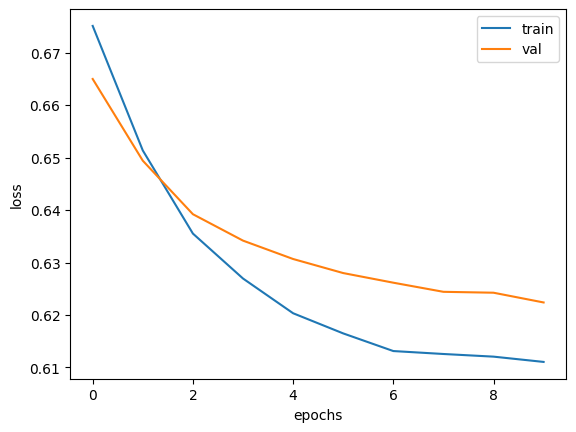

In [ ]:
print(DEVICE)
NUM_GENRES = ohe.get_feature_names_out().size


model = BERTClassifier(MODEL, NUM_GENRES)
model = model.to(DEVICE)

# Заморозим все слои BERT
for param in model.bert.parameters():
    param.requires_grad = False

# Убеждаемся, что линейная голова не заморожена
for param in model.linear.parameters():
    param.requires_grad = True

for param in model.linear2.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

n_epochs = 10
# n_epochs = 5
# n_epochs = 1

train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=True)

train_loss_list, val_loss_list = train(model, train_dataloader, test_dataloader, optimizer, criterion, n_epochs)

In [ ]:
test_dataloader2 = DataLoader(test_dataset, batch_size=40, shuffle=False)
batch = next(iter(test_dataloader))

In [ ]:
lst = np.array([])
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader2):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        genre = batch['genre'].to(DEVICE)
        views = batch['views'].to(DEVICE)

        meanf = batch['meanf'].to(DEVICE)
        grammar = batch['grammar'].to(DEVICE)
        emotion = batch['emotion'].to(DEVICE)
        rhyme_scheme = batch['rhyme_scheme'].to(DEVICE)
        rhythm_estimate = batch['rhythm_estimate'].to(DEVICE)
        rhythm_scheme = batch['rhythm_scheme'].to(DEVICE)

        # outputs = model(input_ids, attention_mask, genre)
        # outputs = model(input_ids, attention_mask, genre, views)
        outputs = model(input_ids, attention_mask, genre, views
                        , meanf
                            , grammar
                            , emotion
                           , rhyme_scheme
                           , rhythm_estimate
                           , rhythm_scheme
                        )
        lst = np.concatenate((lst, outputs.squeeze().cpu().numpy()), axis=0)

100%|██████████| 85/85 [00:05<00:00, 16.94it/s]


In [ ]:
pd.Series((lst > 0.5).astype(int)).value_counts()

,count
0,2228
1,1172


In [ ]:
test_data_mod.rating.value_counts()

,count
rating,
0,1876
1,1524


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
# 0.6991, 0.6541 = txt+genre+veiws + 10 epochs + frozen + 250 + linX2(128)
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6991704161979753, 0.6541176470588236)

In [ ]:
# 0.6869, 0.6432 = all-rhyme + 10 epochs + frozen + 250 + linX2(128)
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6869568076378512, 0.643235294117647)

In [ ]:
# 0.6855, 0.6367  = all + 10 epochs + frozen + 250 + linX2(128)
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6855636748764613, 0.6367647058823529)

In [ ]:
# 0.6433, 0.6091 = all + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6433090453245582, 0.6091176470588235)

In [ ]:
# 0.6418, 0.612 = txt+genre+veiws+ry + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6418372143780535, 0.6120588235294118)

In [ ]:
# 0.654, 0.6097 = txt+genre+veiws+mge+r_e + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6540816026728001, 0.6097058823529412)

In [ ]:
# 0.6629, 0.6173 = txt+genre+veiws+r_e + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6629886632641069, 0.6173529411764705)

In [ ]:
# 0.59, 0.5732 = txt+genre+veiws+mge + 4 epochs + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.5900884357738865, 0.5732352941176471)

In [ ]:
# 0.6568, 0.6123 = txt+genre+veiws+mge + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6568250214059064, 0.6123529411764705)

In [ ]:
# 0.6590, 0.6152 = txt+genre_veiws + 10 epochs + frozen + 210
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6590460590747053, 0.6152941176470588)

In [ ]:
# 0.6621, 0.6123 = txt+genre_veiws + 10 epochs + frozen + 344
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6621915380913208, 0.6123529411764705)

In [ ]:
# 0.6670, 0.62 = txt+genre_veiws + 10 epochs + frozen + 250
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.6670694264895993, 0.62)

In [ ]:
# 0.5681, 0.5558 = txt+genre+veiws/5epochs
roc_auc_score(test_data_mod.rating, lst), accuracy_score(test_data_mod.rating, (lst > 0.5).astype(int))

(0.5681961746386179, 0.5558823529411765)

In [ ]:
import pandas as pd

# 0.6020446138262567, 0.5882
pd.DataFrame({
    'params': ['tf-idf', 'txt+genre+veiws/5epochs/344tok', 'txt+genre+veiws/10epochs/344tok/frozen',
               'txt+genre+veiws/10epochs/250tok/frozen', 'txt+genre+veiws/10epochs/210tok/frozen'],
    'ROC-AUC': [0.602, 0.5681, 0.6621, 0.6670, 0.6590],
    'Accuracy': [0.5882, 0.5558, 0.6123, 0.62, 0.6152]
}).sort_values('ROC-AUC', ascending=False)

,params,ROC-AUC,Accuracy
3,txt+genre+veiws/10epochs/250tok/frozen,0.6670,0.6200
2,txt+genre+veiws/10epochs/344tok/frozen,0.6621,0.6123
4,txt+genre+veiws/10epochs/210tok/frozen,0.6590,0.6152
0,tf-idf,0.6020,0.5882
1,txt+genre+veiws/5epochs/344tok,0.5681,0.5558


In [ ]:
import pandas as pd

# 0.6020446138262567, 0.5882
pd.DataFrame({
    'params': ['tf-idf', 't+g+v/5epochs/344tok', 't+g+v/10epochs/344tok/frozen',
               't+g+v/10epochs/250tok/frozen', 't+g+v/10epochs/210tok/frozen',
               't+g+v+m+g+e/10epochs/frozen/250tok', 't+g+v+m+g+e/4epochs/250tok',
               't+g+v+r_e/10epochs/frozen/250tok', 't+g+v+m+g+e+r_e/10epochs/frozen/250tok',
               't+g+v+ry/10epochs/frozen/250tok', 'all/10epochs/frozen/250tok', 'all/10epochs/frozen/250tok/linX2(128)',
               'all-rhyme/10 epochs/frozen/250tok/linX2(128)', 't+g+v/10 epochs/frozen/250tok/linX2(128)'],
    'ROC-AUC': [0.602, 0.5681, 0.6621, 0.6670, 0.6590, 0.6568, 0.59, 0.6629, 0.654, 0.6418, 0.6433, 0.6855, 0.6869, 0.6991],
    'Accuracy': [0.5882, 0.5558, 0.6123, 0.62, 0.6152, 0.6123, 0.5732, 0.6173, 0.6097, 0.612, 0.6091, 0.6367, 0.6432, 0.6541]
}).sort_values('ROC-AUC', ascending=False).to_csv('res_exp.csv', index=False)